In [3]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xgcm
#from xgcm.autogenerate import generate_grid_ds
from functools import partial
from scipy.signal import butter, filtfilt
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

#from mitequinox.utils import *

In [4]:
from dask.distributed import Client, LocalCluster
    #
cluster = LocalCluster()
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 128,Total memory: 251.08 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35141,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 128
Started: Just now,Total memory: 251.08 GiB
Comm: tcp://127.0.0.1:43935,Total threads: 8
Dashboard: http://127.0.0.1:37245/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:42697,


2025-04-23 16:39:07,641 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2025-04-23 16:39:15,445 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2025-04-23 16:39:28,403 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2025-04-23 16:39:48,894 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2025-04-23 16:40:07,721 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2025-04-23 16:40:18,046 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2025-04-23 16:40:28,236 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2025-04-23 16:40:51,686 - distributed.utils_perf - WARNING - full garbage collections took

_________
# 1. Read LLC4320 output


In [5]:
out_dir_zarr = '/meddy/yuxlong5/data/data_rechunk/'

grid = xr.open_dataset('/meddy/yuxlong5/data/data_zarr/Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds = xr.merge([ds_U,ds_V,grid])
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (time: 9415, depth: 52, lat: 201, lon_g: 177, lat_g: 201, lon: 177)
Coordinates: (12/21)
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g    (lon_g) float32 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * lat_g    (lat_g) float32 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    ...       ...
    dxG      (lat_g, lon) float32 ...
    dyG      (lat, lon_g) float32 ...
    rA       (lat, lon) float32 ...
    rAz      (lat_g, lon_g) float32 ...
    rAw      (lat, lon_g) float32 ...
    rAs      (lat_g, lon) float32 ...
Data variables:
    U        (time, depth, lat, lon_g) float32 dask.array<chunksize=(9415, 1, 1, 177), meta=np.ndarray>
    V        (time, depth, lat_g, lon) float

In [7]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'}}, periodic=['X', 'Y'], autoparse_metadata=False)
print(gridx)

<xgcm.Grid>
X Axis (periodic, boundary='periodic'):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic, boundary='periodic'):
  * center   lat --> left
  * left     lat_g --> center


In [8]:
def butter_filter(x, b, a):
    return xr.apply_ufunc(partial(filtfilt, b, a),
                          x.chunk(),
                          dask='parallelized',
                          output_dtypes=[x.dtype],
                          kwargs={'axis': 0})

________
# 2. Calculate $\Pi_\omega$ using the Coarse-graining method

In [9]:
cut_1 = 1/13/3600    # 13 h 
#cut_1 = 1/24/3600    # 1 day 
cut_5 = 1/120/3600   # 5 days

fs = 1/3600
nyq = 0.5*fs
cut_1d = cut_1/nyq
cut_5d = cut_5/nyq

b, a = butter(4, cut_1d , 'low')
c, d = butter(4, cut_5d, 'low')

In [10]:
du_dx = gridx.diff(butter_filter(ds.U, b, a), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, b, a), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, b, a), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, b, a), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, b, a), 'X')-gridx.interp(butter_filter(ds.U, b, a)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, b, a), 'Y')-gridx.interp(butter_filter(ds.V, b, a)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), b, a) -butter_filter(gridx.interp(ds.V,'Y'), b, a)*butter_filter(gridx.interp(ds.U,'X'), b, a) )*(du_dy+dv_dx)

PI_cg_1d = -(PI_1+PI_2+PI_3)
PI_cg_1d

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<neg, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [10]:
du_dx = gridx.diff(butter_filter(ds.U, c, d), 'X')/gridx.interp(ds.dxG, 'Y')
dv_dy = gridx.diff(butter_filter(ds.V, c, d), 'Y')/gridx.interp(ds.dyG, 'X')
du_dy = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.U, c, d), 'Y')/gridx.interp(ds.dyC, 'X'), 'X'), 'Y')
dv_dx = gridx.interp(gridx.interp(gridx.diff(butter_filter(ds.V, c, d), 'X')/gridx.interp(ds.dxC, 'Y'), 'X'), 'Y')

PI_1 = (gridx.interp(butter_filter(ds.U**2, c, d), 'X')-gridx.interp(butter_filter(ds.U, c, d)**2, 'X'))*du_dx
PI_2 = (gridx.interp(butter_filter(ds.V**2, c, d), 'Y')-gridx.interp(butter_filter(ds.V, c, d)**2, 'Y'))*dv_dy
PI_3 = (butter_filter(gridx.interp(ds.V,'Y')*gridx.interp(ds.U,'X'), c, d) -butter_filter(gridx.interp(ds.V,'Y'), c, d)*butter_filter(gridx.interp(ds.U,'X'), c, d) )*(du_dy+dv_dx)

PI_cg_5d = -(PI_1+PI_2+PI_3)
PI_cg_5d

,Array,Chunk
Bytes,64.89 GiB,6.29 MiB
Shape,"(9415, 52, 201, 177)","(9415, 1, 1, 175)"
Count,2365610 Tasks,31356 Chunks
Type,float32,numpy.ndarray


In [11]:
out_dir_store = '/meddy/yuxlong5/data/result/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [12]:
# works better with a few workers but a lot of memories
VV = ['PI_cg_1d']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_1d_single = PI_cg_1d.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_1d_single = PI_cg_1d_single.chunk(chunks)
        PI_cg_1d_single = np.real(PI_cg_1d_single).rename('PI_cg_1d_single')     
        PI_cg_1d_single = PI_cg_1d_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_1d_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed


2025-04-23 16:39:47,433 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)


depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed


2025-04-23 16:40:50,219 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready processed
depth=34 - allready processed
depth=35 - allready processed
depth=36 - allready processed
depth=37 - allready processed
depth=38 - allready processed
depth=39 - all

In [13]:
VV = ['PI_cg_5d']

for depth in depth_all:
    
    for vv in VV:
        
        PI_cg_5d_single = PI_cg_5d.isel(depth=depth)
        chunks = {'lat': 1, 'lon': 177, 'time':9415}            
        PI_cg_5d_single = PI_cg_5d_single.chunk(chunks)
        PI_cg_5d_single = np.real(PI_cg_5d_single).rename('PI_cg_5d_single')     
        PI_cg_5d_single = PI_cg_5d_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        PI_cg_5d_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

____________________
# 3. Results

## 1-5 day band

In [14]:
# Pi_omega at 1-5d band

out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'

D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_1d = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg_1d.PI_cg_1d_single

D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single

PI_cg_1d = np.real(PI_cg_1d).rename('PI_cg_1d')
PI_cg_5d = np.real(PI_cg_5d).rename('PI_cg_5d')

PI_cg = PI_cg_5d-PI_cg_1d
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)
print(PI_cg)

file_out = out_dir_store+'PI_cg_butter.zarr'
PI_cg.to_dataset().to_zarr(file_out, mode='w')  

<xarray.DataArray 'PI_cg' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<real, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2


In [15]:
### spatial mean and cumulative integral

out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'

D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_1d = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg_1d.PI_cg_1d_single

D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single

PI_cg_1d = np.real(PI_cg_1d).rename('PI_cg_1d')
PI_cg_5d = np.real(PI_cg_5d).rename('PI_cg_5d')

PI_cg = PI_cg_5d-PI_cg_1d
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)
#print(PI_cg)

PI_cg_smean = PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat'])
PI_cg_smean = np.real(PI_cg_smean).rename('PI_cg_smean')
PI_cg_cumsum = 3600*PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).cumsum(['time'])
PI_cg_cumsum = np.real(PI_cg_cumsum).rename('PI_cg_cumsum')
PI_cg_all = xr.merge([PI_cg_smean,PI_cg_cumsum])
print(PI_cg_all)

file_out = out_dir_store+'PI_cg_butter_all.zarr'
PI_cg_all.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:       (depth: 52, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    PI_cg_smean   (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    PI_cg_cumsum  (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>


## 5 days

In [16]:
# Pi_omega at 5d 

out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'

D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single

PI_cg_5d = np.real(PI_cg_5d).rename('PI_cg_5d')

PI_cg = PI_cg_5d
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)
print(PI_cg)

file_out = out_dir_store+'PI_cg_butter_5d.zarr'
PI_cg.to_dataset().to_zarr(file_out, mode='w')  

<xarray.DataArray 'PI_cg' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<real, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2


In [17]:
### spatial mean and cumulative integral

out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'

D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single

PI_cg_5d = np.real(PI_cg_5d).rename('PI_cg_5d')

PI_cg = PI_cg_5d
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)

PI_cg_smean = PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat'])
PI_cg_smean = np.real(PI_cg_smean).rename('PI_cg_smean')
PI_cg_cumsum = 3600*PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).cumsum(['time'])
PI_cg_cumsum = np.real(PI_cg_cumsum).rename('PI_cg_cumsum')
PI_cg_all = xr.merge([PI_cg_smean,PI_cg_cumsum])
print(PI_cg_all)

file_out = out_dir_store+'PI_cg_butter_5d_all.zarr'
PI_cg_all.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:       (depth: 52, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    PI_cg_smean   (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    PI_cg_cumsum  (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>


## 1 day

In [15]:
# Pi_omega at 1d 

out_dir_store = '/meddy/yuxlong5/data/result/'

D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg = xr.concat(D, dim='depth')
PI_cg = PI_cg.PI_cg_1d_single
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)
print(PI_cg)

file_out = out_dir_store+'PI_cg_butter_1d.zarr'
PI_cg.to_dataset().to_zarr(file_out, mode='w')  

In [19]:
### spatial mean and cumulative integral

out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'


D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]
PI_cg = xr.concat(D, dim='depth')
PI_cg = PI_cg.PI_cg_1d_single
PI_cg = np.real(PI_cg).rename('PI_cg')
chunks = {'lat':1, 'lon':177,'time': 9415, 'depth':1}
PI_cg = PI_cg.chunk(chunks)

PI_cg_smean = PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat'])
PI_cg_smean = np.real(PI_cg_smean).rename('PI_cg_smean')
PI_cg_cumsum = 3600*PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).cumsum(['time'])
PI_cg_cumsum = np.real(PI_cg_cumsum).rename('PI_cg_cumsum')
PI_cg_all = xr.merge([PI_cg_smean,PI_cg_cumsum])
print(PI_cg_all)

file_out = out_dir_store+'PI_cg_butter_1d_all.zarr'
PI_cg_all.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:       (depth: 52, time: 9415)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * time          (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    PI_cg_smean   (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>
    PI_cg_cumsum  (depth, time) float32 dask.array<chunksize=(1, 9415), meta=np.ndarray>


___________
# 4. Read results

In [15]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_1d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_1d = xr.concat(D, dim='depth')
PI_cg_1d = PI_cg_1d.PI_cg_1d_single
print(PI_cg_1d)
print('\n data size: %.1f GB' %(PI_cg_1d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_1d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

 data size: 69.7 GB


In [14]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
D = [xr.open_zarr(out_dir_store+'PI_cg_5d_d%02d.zarr'%(depth)) for depth in range(52)]

PI_cg_5d = xr.concat(D, dim='depth')
PI_cg_5d = PI_cg_5d.PI_cg_5d_single
print(PI_cg_5d)
print('\n data size: %.1f GB' %(PI_cg_5d.nbytes / 1e9))

<xarray.DataArray 'PI_cg_5d_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Dimensions without coordinates: depth

 data size: 69.7 GB


In [5]:
out_dir_store = '/home1/scratch/xyu/KE/Pi_omega/cg_butter/'
PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter.zarr')
PI_cg = PI_cg.PI_cg
PI_cg

<xarray.DataArray 'PI_cg' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<zarr, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

In [9]:
out_dir_store = '/meddy/yuxlong5/data/result/'

PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter_1d.zarr')
PI_cg = PI_cg.PI_cg

out_dir = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'
ds_MLD = xr.open_zarr(out_dir+'mld_filter.zarr')
ds_MLD

ds = xr.merge([PI_cg,ds_MLD])
# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime
time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 
ds.PI_cg.persist()
ds

<xarray.Dataset>
Dimensions:     (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
Data variables:
    PI_cg       (depth, time, lat, lon) float32 dask.array<chunksize=(1, 9415, 1, 177), meta=np.ndarray>
    mld_filter  (time, lat, lon) float32 dask.array<chunksize=(9415, 201, 177), meta=np.ndarray>

In [16]:
out_dir_store = '/meddy/yuxlong5/data/result/'

PI_cg = xr.open_zarr(out_dir_store+'PI_cg_butter_1d.zarr')
PI_cg = PI_cg.PI_cg
ds = PI_cg
ds

<xarray.DataArray 'PI_cg' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<open_dataset-1ccc3d87e82fa198d000415a2cacf5dcPI_cg, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 1, 177), chunktype=numpy.ndarray>
Coordinates:
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float32 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float32 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2

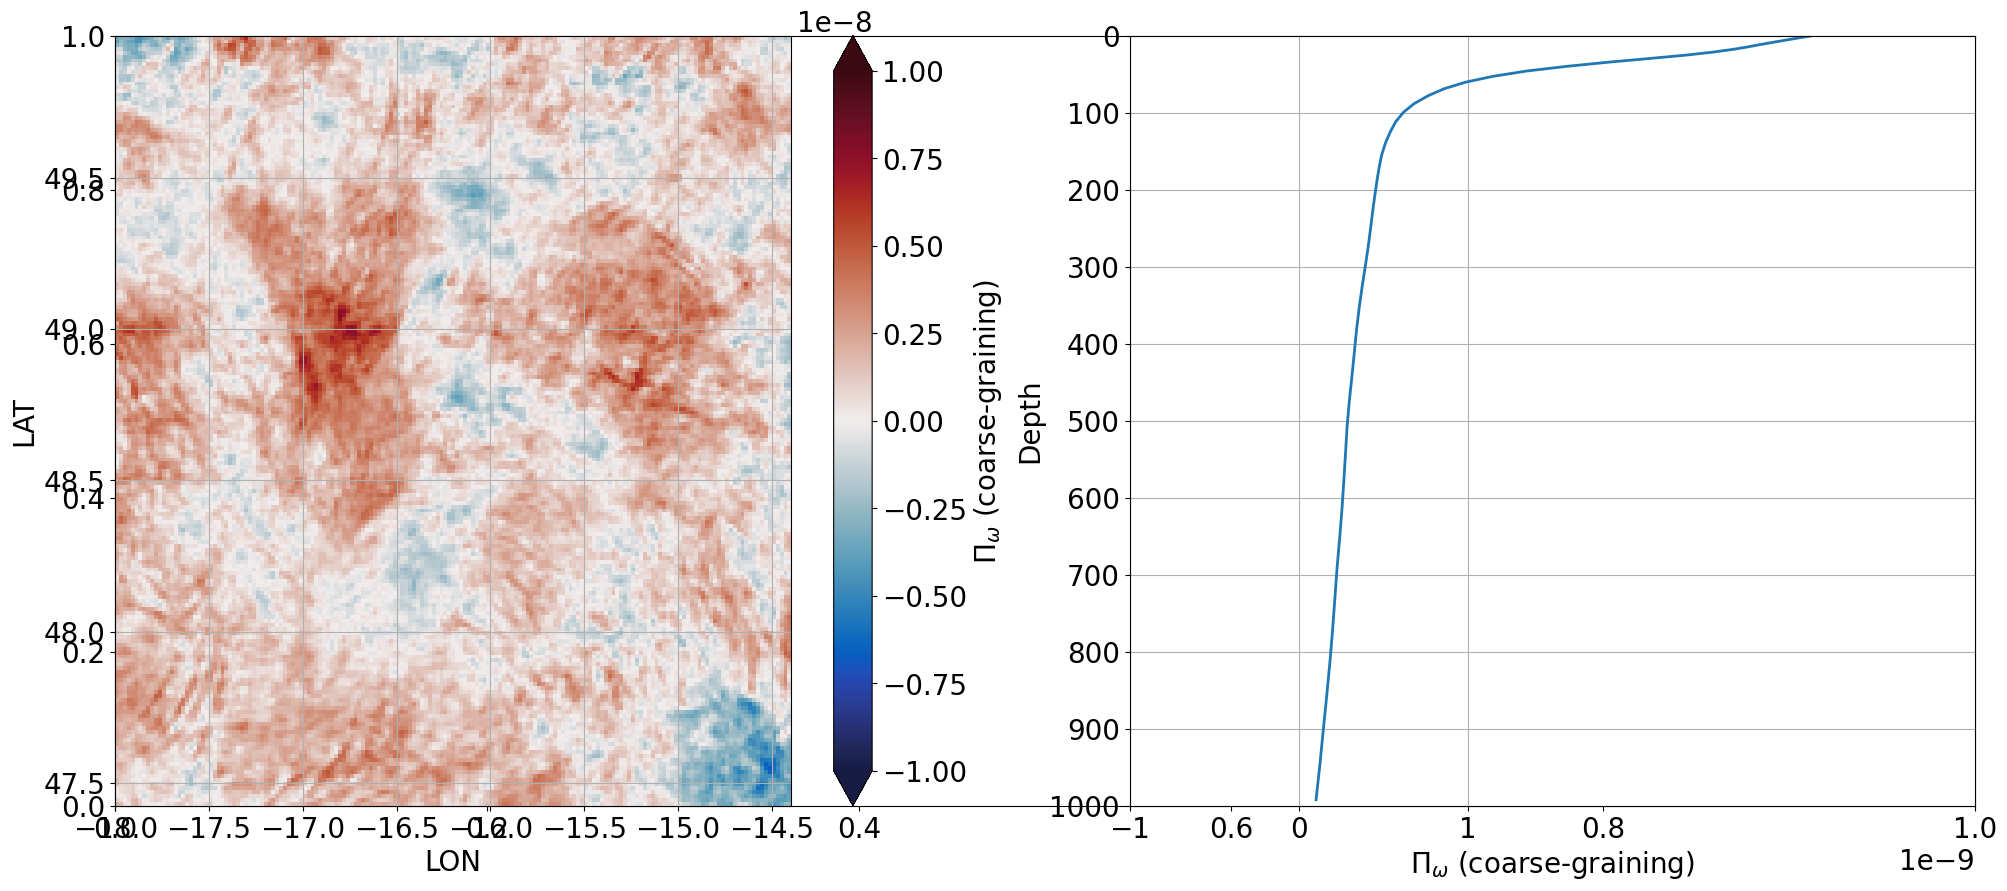

In [20]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.subplot(121)
cax = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(1,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
ds.isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-1e-9,4e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([ -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


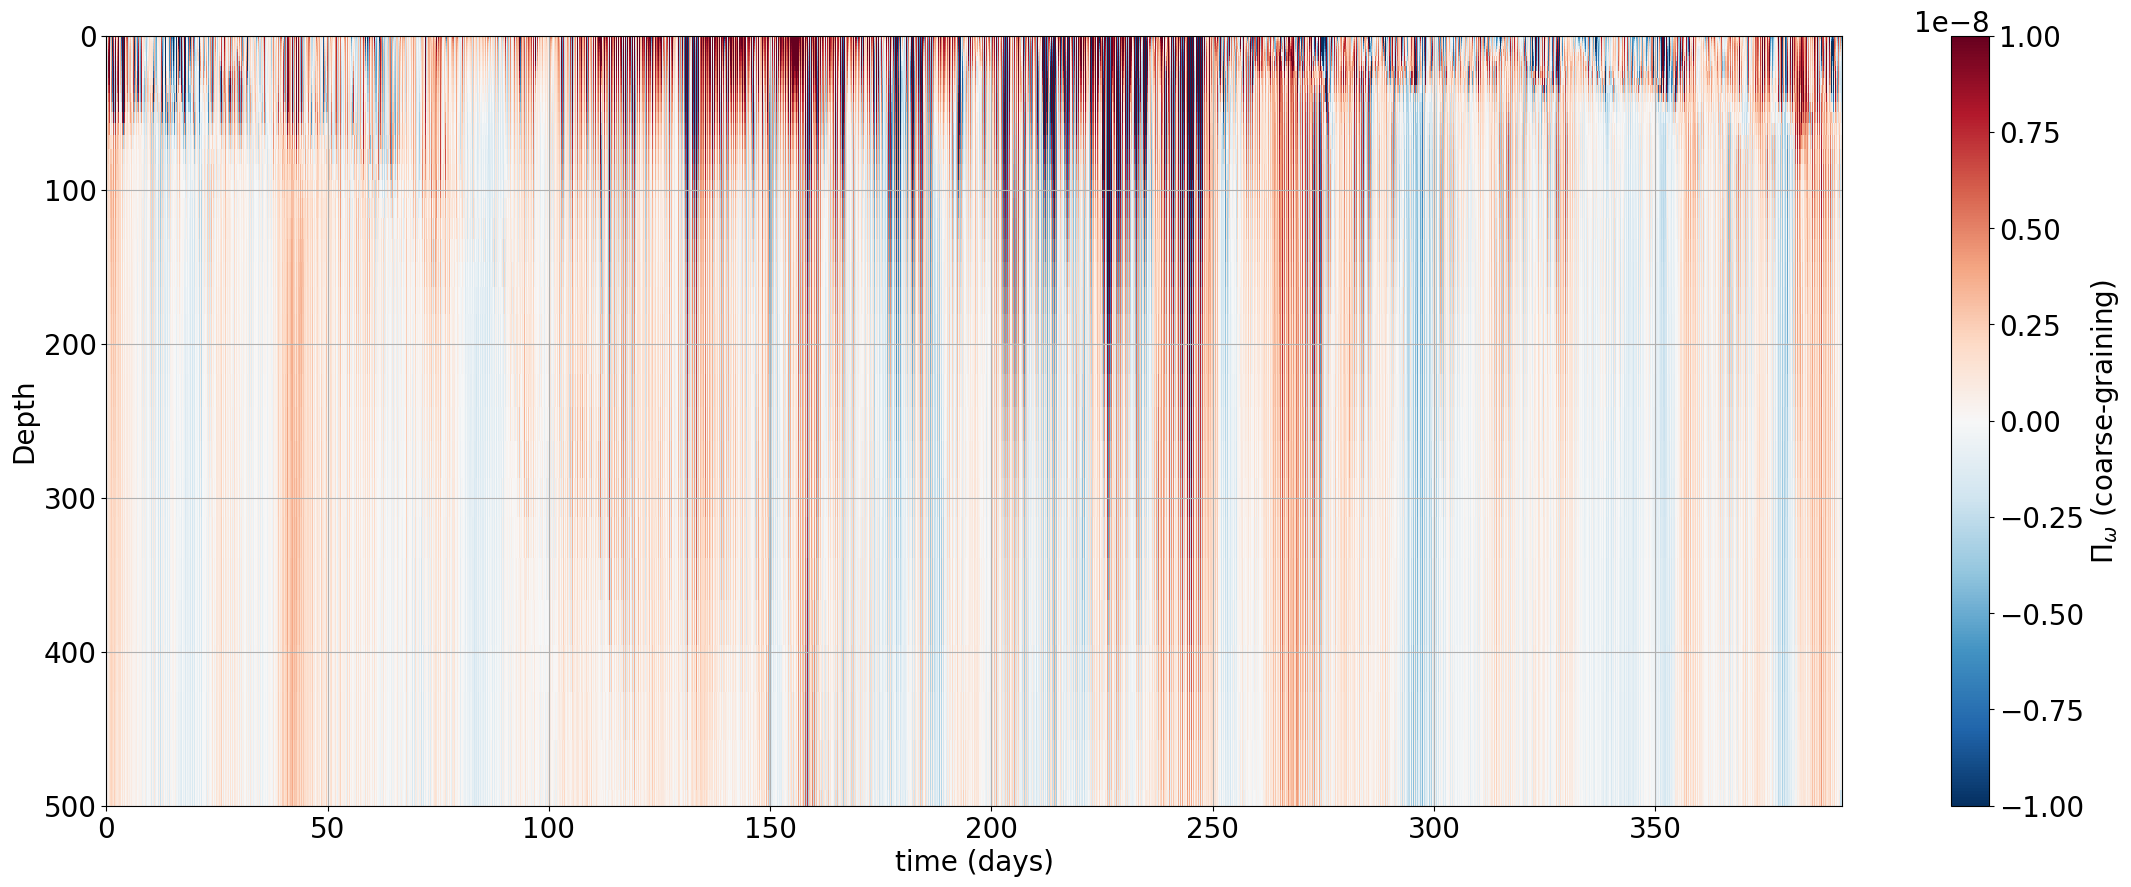

In [25]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = ds.isel(lat=slice(3,-3),lon=slice(3,-3)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-1e-8,vmax=1e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
#ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
#ax.set_xlim(['2011-09', '2012-09-05'])
#ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
#ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together2_coarse_graining.png')

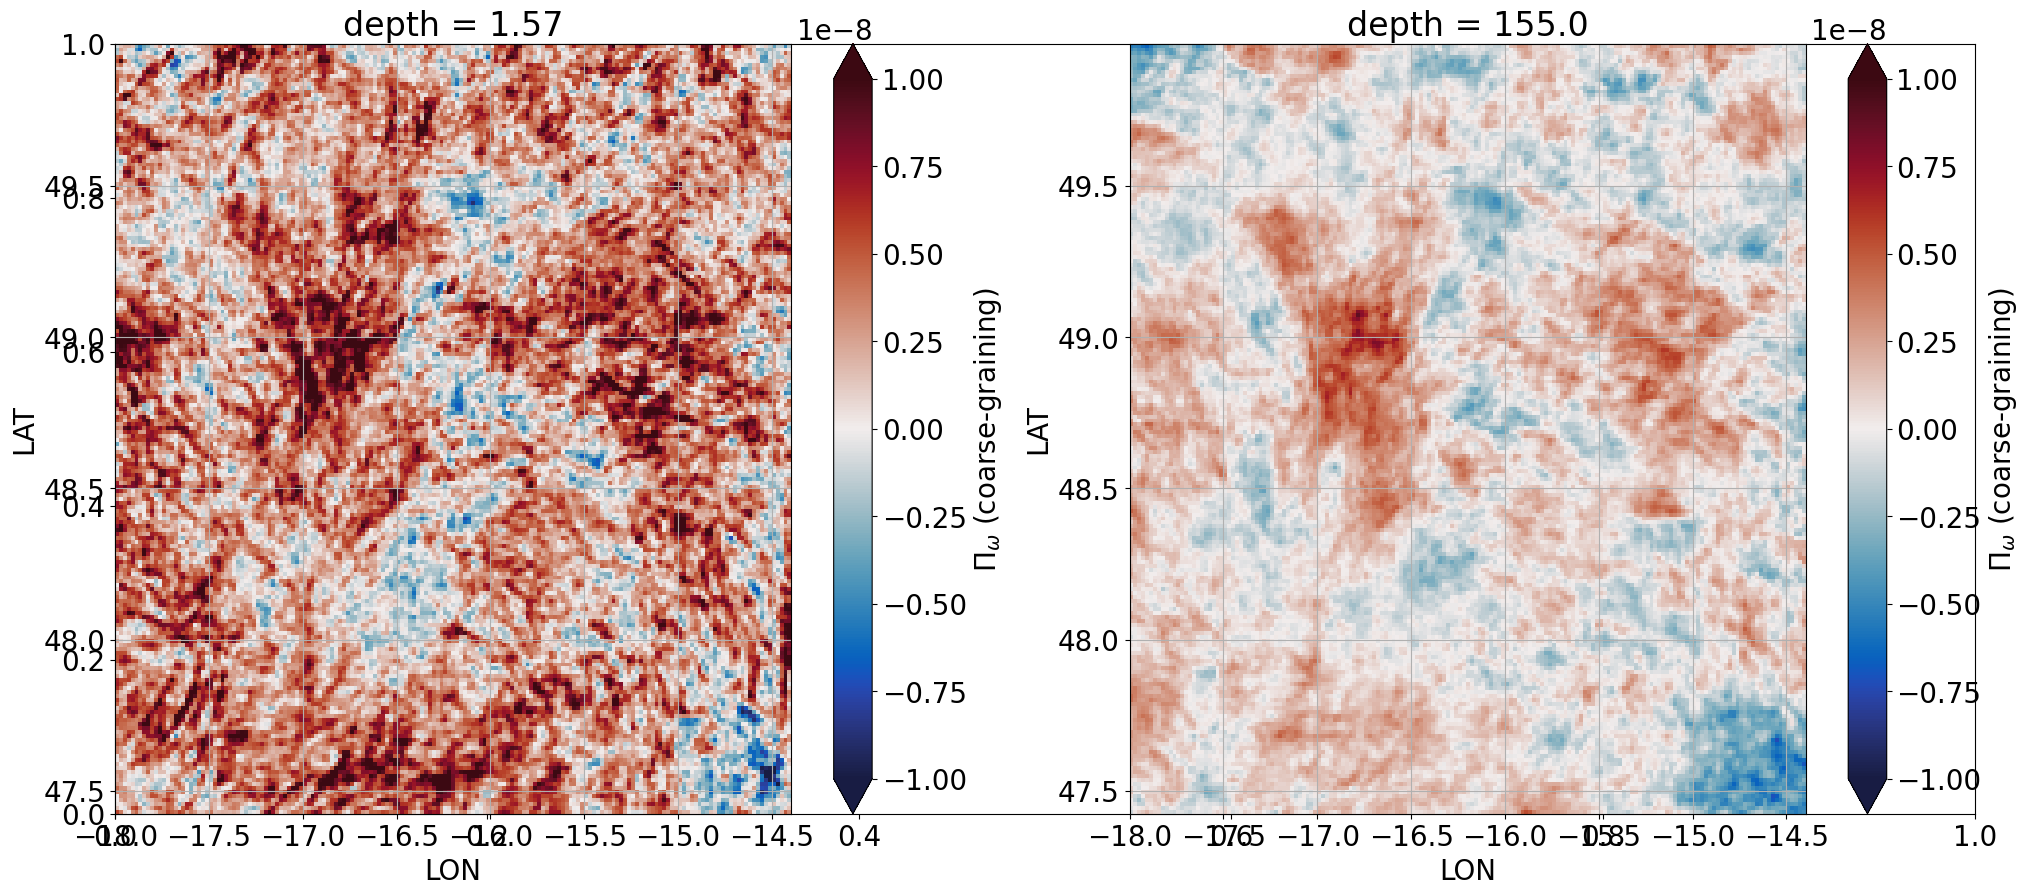

In [23]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(24,10))

ax = plt.subplot(121)
cax = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=1).mean(['time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(122)
cax = ds.isel(lat=slice(2,-2),lon=slice(2,-2),depth=25).mean(['time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)


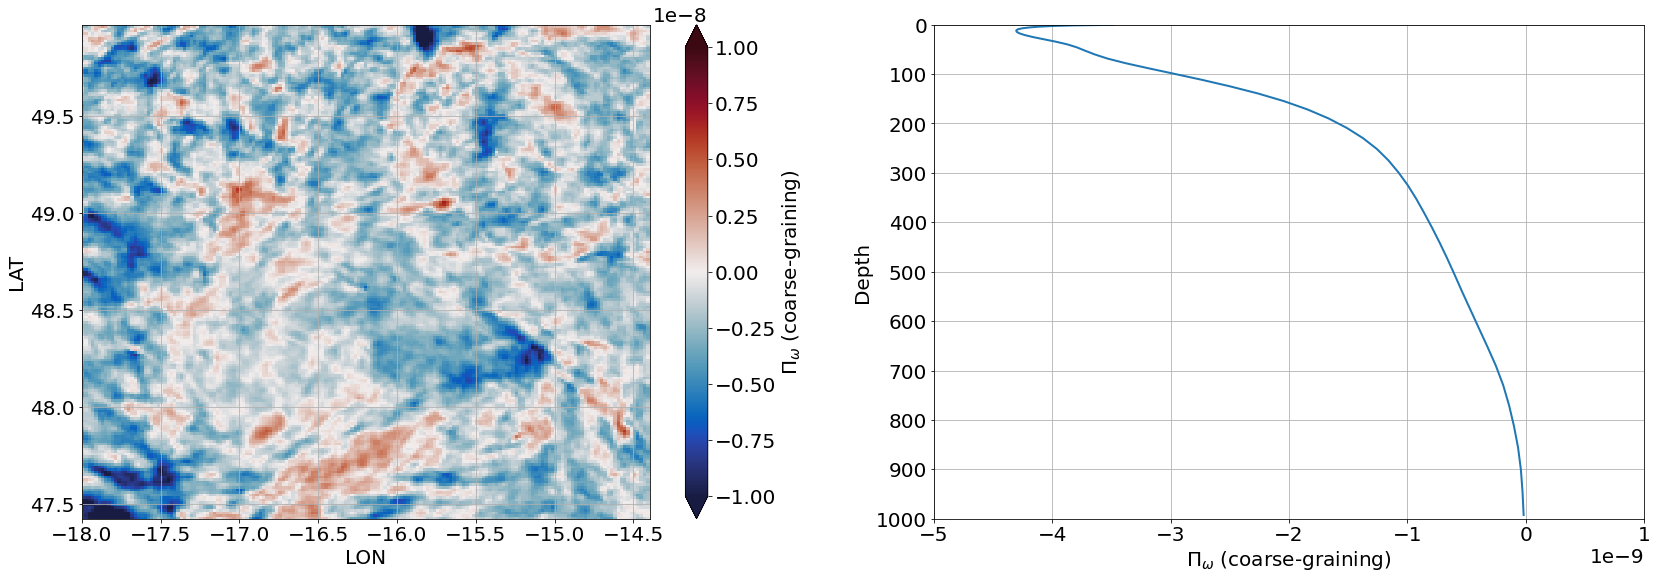

In [11]:
plt.rc('font', size=20) 

font_size=20

fig, ax = plt.subplots(figsize=(28,20))
ax = plt.subplot(221)
cax = ds.PI_cg.isel(lat=slice(2,-2),lon=slice(2,-2),depth=slice(10,50)).mean(['depth','time']).plot(x='lon', y='lat',cmap=cm.balance, vmin=-1e-8,vmax=1e-8, add_colorbar = False)
ax.grid()
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('LON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
ds.PI_cg.isel(lat=slice(2,-2),lon=slice(2,-2),time=slice(10,-10)).mean(['time','lat','lon']).plot(y='depth', yincrease=False, linewidth=2)
ax.grid()
ax.set_xlim([-5e-9,1e-9])
ax.set_ylim([1000., 0.])
ax.set_xticks([-5e-9, -4e-9,-3e-9, -2e-9, -1e-9, 0., 1e-9])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('$\Pi_{\omega}$ (coarse-graining)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_yticks([1000., 900,800,700,600,500,400,300,200,100,0.])


[Text(0, 0, '11-10'),
 Text(0, 0, '11-11'),
 Text(0, 0, '11-12'),
 Text(0, 0, '12-01'),
 Text(0, 0, '12-02'),
 Text(0, 0, '12-03'),
 Text(0, 0, '12-04'),
 Text(0, 0, '12-05'),
 Text(0, 0, '12-06'),
 Text(0, 0, '12-07'),
 Text(0, 0, '12-08'),
 Text(0, 0, '12-09')]

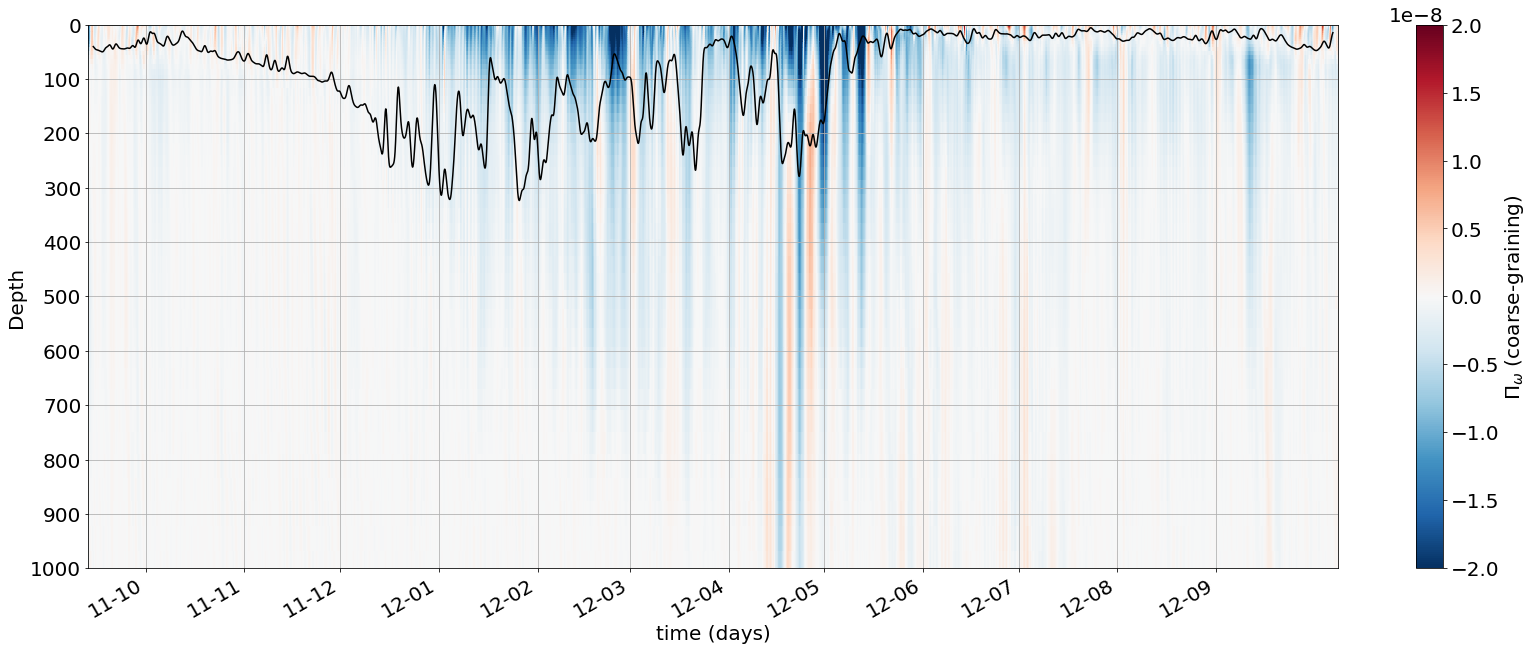

In [12]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = ds.PI_cg.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap='RdBu_r', vmin=-2e-8,vmax=2e-8,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('$\Pi_{\omega}$ (coarse-graining)', fontsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_yticks([500,400,300,200,100,0.])
ds.mld_filter.mean(['lat','lon']).plot(x='time',yincrease=False, color='black')
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)
ax.set_xlim(['2011-09', '2012-09-05'])
ax.set_xticks(['2011-09','2011-10','2011-11', '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05', '2012-06', '2012-07', '2012-08', '2012-09'])
ax.set_xticklabels(['Sep','Oct', 'Nov', 'Dec', 'Jan (2012)', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'])

#plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/Pi_omega_together2_coarse_graining.png')

In [21]:
cluster.close()